## Proyecto 2 - Modelo de Clasificación Supervisada para Evaluar Calidad de Vinos

### Integrantes:

- Santiago Simmonds Rodriguez
- Cristian David Baez
- German Alonso Rodriguez
- Jose David Mariño

### Informe

* Exploración de datos
* Preparación de datos para entrenar modelos
* Generación de base de entrenamiento y testeo

### Informe de rendimiento de modelos posterior a la implementación

* Resultados de rendimientos de cada uno de los modelos en la base de testeo
* Identificación de sobreajuste

**Problema**

Se cuenta con un set de datos con las características físicas y químicas de la variedad de vino RED y WHITE. La combinación de características da como resultado la variable objetivo de calidad del vino `quality`.

Se busca obtener un modelo de clasificación supervisada para la calidad de vino RED y obtener métricas de desempeño del modelo.

In [273]:
# importar librerías

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


sns.set_style("whitegrid")

In [274]:
# cargar datos

df1 = pd.read_csv('./data_raw/winequality-red.csv', sep=';')
df1['red'] = 1
df2 = pd.read_csv('./data_raw/winequality-white.csv', sep=';')
df2['red'] = 0
df = pd.concat([df1, df2], axis=0)

In [275]:
# explorar datos

print(pd.concat([df.head(),df.tail()]))

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4              0.70         0.00             1.9      0.076   
1               7.8              0.88         0.00             2.6      0.098   
2               7.8              0.76         0.04             2.3      0.092   
3              11.2              0.28         0.56             1.9      0.075   
4               7.4              0.70         0.00             1.9      0.076   
4893            6.2              0.21         0.29             1.6      0.039   
4894            6.6              0.32         0.36             8.0      0.047   
4895            6.5              0.24         0.19             1.2      0.041   
4896            5.5              0.29         0.30             1.1      0.022   
4897            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0      

In [276]:
# información general

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  red                   6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 710.6 KB
None


**Resúmen de datos**

El dataset tiene tamaño (6497, 13), todas las variables son numéricas tipo `float64`, excepto la variable objetivo `quality` y `red` que son numpericas de tipo `int64`. A diferencia de las demás variables, la variable objetivo debería ser de tipo `object`, `category` o `class`, ya que queremos entrenar un modelo de clasificación supervisada, la etiqueta de cada registro es la clasificación a la que queremos acercarnos.

In [277]:
# cambiar tipo de dato a la variable objetivo

df['quality'] = df['quality'].astype('category')

In [278]:
# configurar pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)

# resumen estadístico
print(df.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000         

In [279]:
# revisar valores nulos

print(df.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
red                     0
dtype: int64


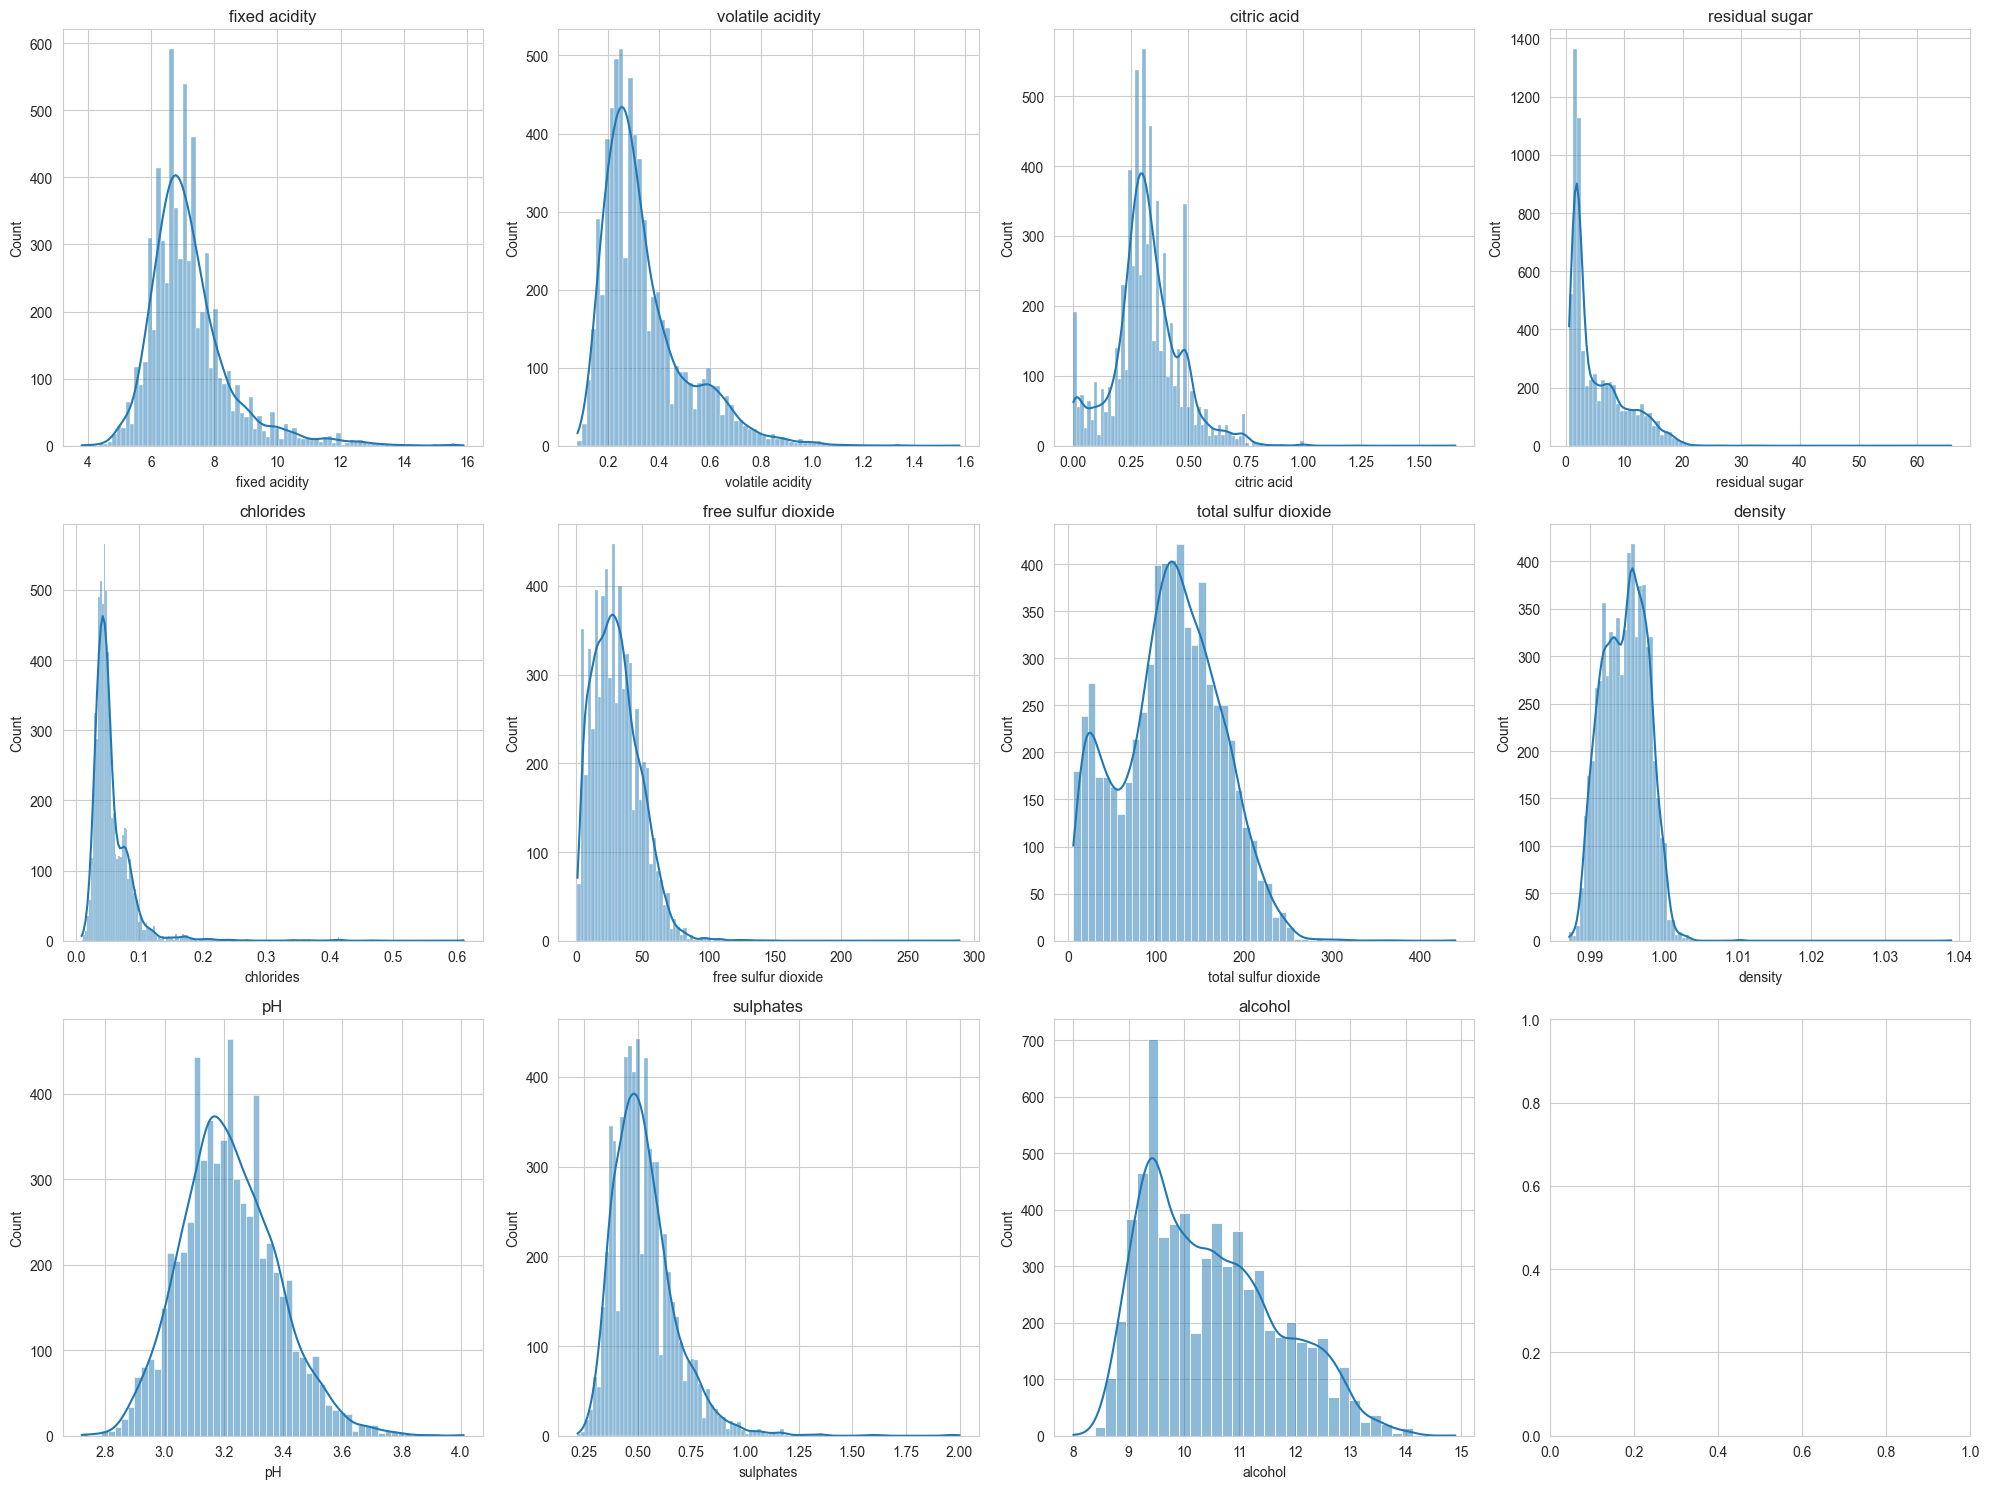

In [280]:
# distribución de las variables predictoras

fig, ax = plt.subplots(3, 4, figsize=(20, 15))
for i, ax in enumerate(ax.flatten()):
    if i < 11:
        sns.histplot(df.iloc[:, i], ax=ax, kde=True)
        ax.set_title(df.columns[i])
plt.tight_layout()
plt.show()

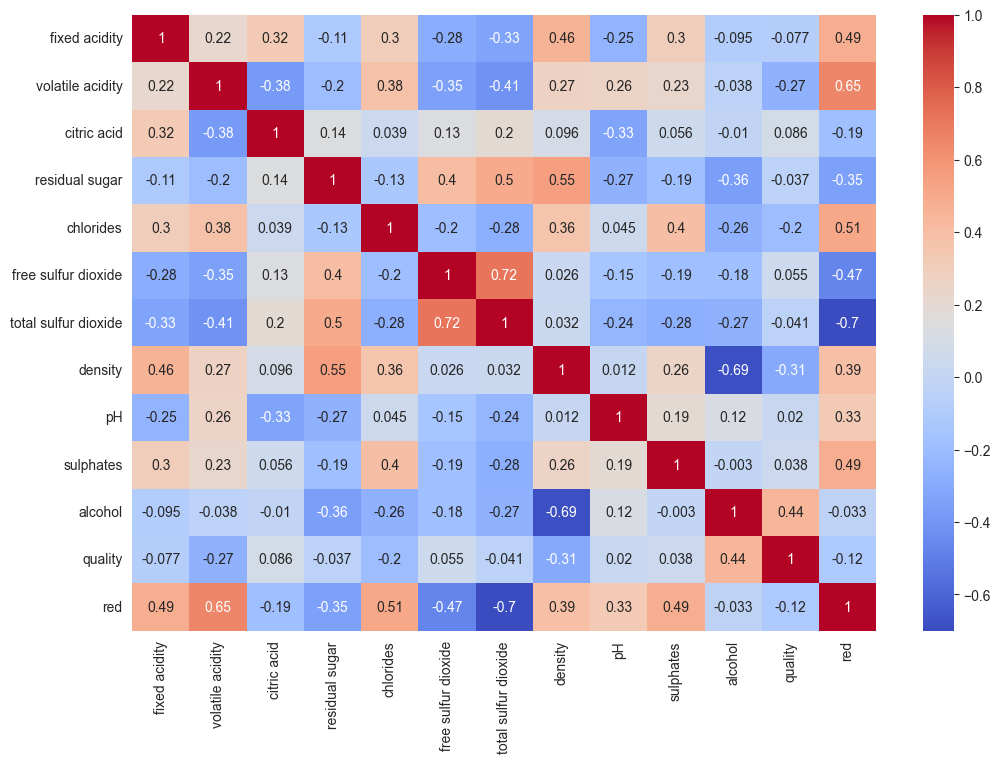

In [281]:
# correlación entre variables predictoras

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

**Análisis de las variables predictoras**

Encontramos que las variables predictoras tiene tienen, en su mayoría sesgo derecho, excepto la variable `pH` que opresentan una distribución centrada en la media, con baja dispersión y colas cortas. La distribución de las variables con sesgo derecho puede indicar mayor concentración de registros en ciertas calidades de vino con combinaciones de características fisico químicas con valores tendientes a cero. Estas caracteristicas nos llevan a pensar que la calidad de vino puede ser muy sensible y así mismo la predicción de la etiqueta calidad del vino. Vale la pena estudiar un poco la etiqueta de calidad de vino para definir su tratamiento para la clasificación.

Por otro lado, encontramos variables con correlaciones muy altas. Estas variables pueden generar redundancia en el modelo, sin embargo se tendrán en cuenta inicialmente, buscando determinar su importancia a partír de los resultados obtenidos.

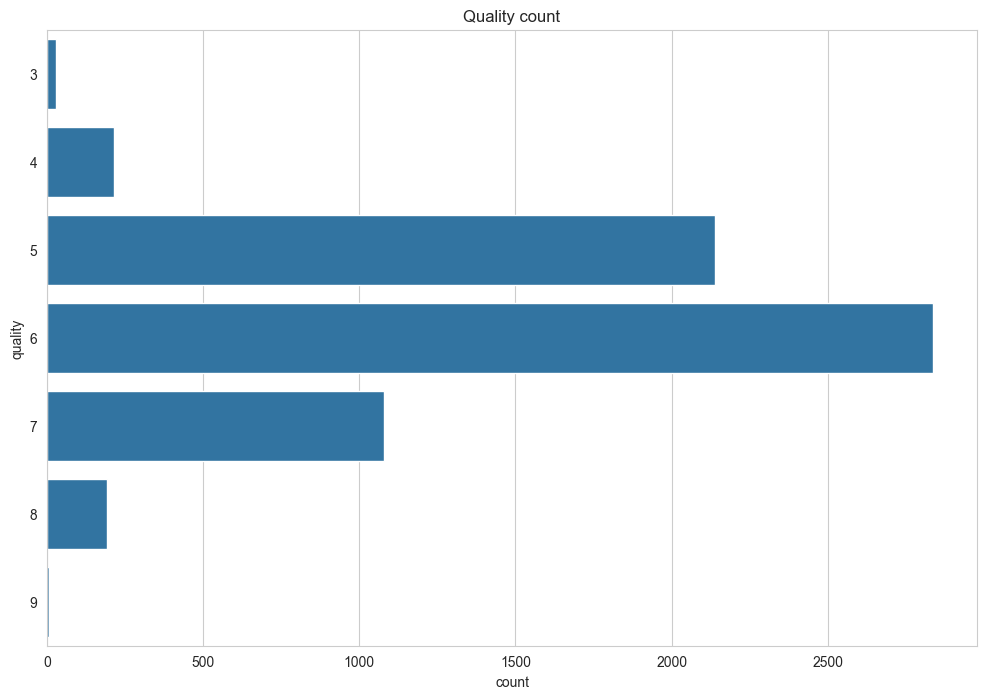

In [282]:
# conteo de la variable objetivo

plt.figure(figsize=(12, 8))
sns.countplot(df['quality'])
plt.title('Quality count')
plt.show()

In [283]:
# conteo de la variable objetivoe en tabla

print(df['quality'].value_counts())

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64


**Variable objetivo**

Vemos que la variable objetivo tiene una distribución de etiquetas casi balanceada, donde la calidad de vino 6, 7, 8 y 9 suman 4113 registros y 3, 4 y 5 suman 2384 registros. Dada la sensibilidad encontrada en la distribución de las variables predictoras, sería conveniente disminuir las etiquetas para concentrar más valores de caracteristicas predictoras en quizas 3 etiquetas (malo, regular, bueno) o 2 etiquetas (bueno, malo). Podemos ensayar el mismo modelo con dos variables objetivo distintas para encontrar cual genera mejor desempeño del modelo y continuar probando otros modelos con la variable objetivo definida.

In [284]:
# separar variables predictoras y variable objetivo

X = df.drop('quality', axis=1)
y = df['quality']

# crear otra variable predictora a partir de y, pero con las etiqueta 'malo', 'bueno', 'regular'ArithmeticError

y_cat = y.map({3: 'malo', 4: 'malo', 5: 'regular', 6: 'regular', 7: 'bueno', 8: 'bueno', 9: 'bueno'})

print(y_cat.value_counts())

quality
regular    4974
bueno      1277
malo        246
Name: count, dtype: int64


In [285]:
# convertir y_cat con LabelEncoder

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_cat = le.fit_transform(y_cat)

print(pd.Series(y_cat).value_counts())

2    4974
0    1277
1     246
Name: count, dtype: int64


In [286]:
# dividir datos en entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5197, 12) (1300, 12) (5197,) (1300,)


In [287]:
# cargar standard scaler

scaler = StandardScaler()

# cargar clasificadores

dt_clf = DecisionTreeClassifier()
rf = RandomForestClassifier()

In [288]:
# crear pipeline 1 de preprocesamiento y clasificación

pipe_dt = pipeline.Pipeline(steps=[('scaler', scaler), ('clf', dt_clf)])

Accuracy: 0.6084615384615385
Classification report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.22      0.23      0.23        43
           5       0.61      0.68      0.64       402
           6       0.68      0.61      0.65       597
           7       0.56      0.59      0.57       215
           8       0.43      0.42      0.42        36
           9       0.00      0.00      0.00         1

    accuracy                           0.61      1300
   macro avg       0.36      0.36      0.36      1300
weighted avg       0.61      0.61      0.61      1300



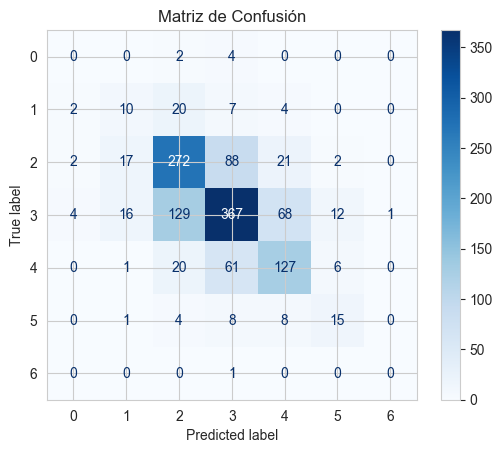

In [289]:
# entrenar modelo

pipe_dt.fit(X_train, y_train)

# predecir

y_pred = pipe_dt.predict(X_test)

# evaluar

print('Accuracy:', accuracy_score(y_test, y_pred))
print('======================================================================')
print('Classification report:\n', classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

In [290]:
# dividir datos de nuevo con la variable y_cat

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5197, 12) (1300, 12) (5197,) (1300,)


Accuracy: 0.796923076923077
Classification report:
               precision    recall  f1-score   support

           0       0.59      0.64      0.61       252
           1       0.30      0.24      0.27        49
           2       0.88      0.86      0.87       999

    accuracy                           0.80      1300
   macro avg       0.59      0.58      0.58      1300
weighted avg       0.80      0.80      0.80      1300



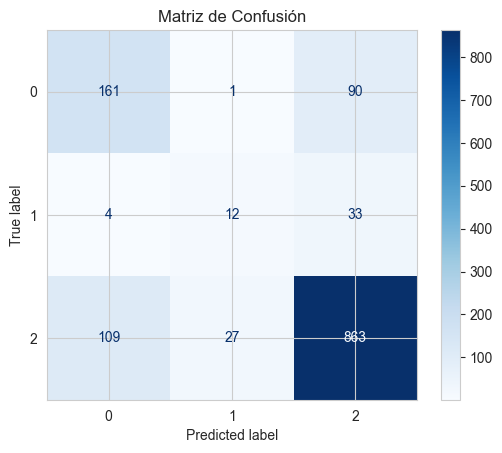

In [291]:
# entrenar modelo

pipe_dt.fit(X_train, y_train)

# predecir

y_pred = pipe_dt.predict(X_test)

# evaluar

print('Accuracy:', accuracy_score(y_test, y_pred))
print('====================================================================')
print('Classification report:\n', classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

**Análisis preliminar con dos enfoques diferentes de la variable objetivo**

Encontramos que evidentemente tenemos mejor resultado la disminuir las etiquetas, y puede notarse mucho mejor resultado en la predicción para la etiqueta donde quedaron más datos concentrados. Tendremos un modelo muy bueno para predicir vino `regular` y muy malo para predecir vino `malo`. Esto podría evitarse si se dividen la etiquetas para vino `malo` y vino `bueno` únicamente, sin embargo para este ejercicio usaremos las tres etiquetas buscando lograr el mejor resultado con diferentes modelos.

Accuracy: 0.8523076923076923
Classification report:
               precision    recall  f1-score   support

           0       0.77      0.59      0.67       252
           1       0.78      0.14      0.24        49
           2       0.87      0.95      0.91       999

    accuracy                           0.85      1300
   macro avg       0.81      0.56      0.61      1300
weighted avg       0.85      0.85      0.84      1300



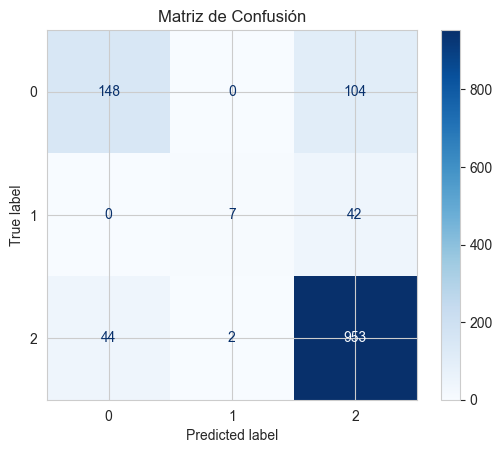

In [292]:
# crear pipeline 2 de preprocesamiento y clasificación

pipe_rf = pipeline.Pipeline(steps=[('scaler', scaler), ('clf', rf)])

# entrenar modelo

pipe_rf.fit(X_train, y_train)

# predecir

y_pred = pipe_rf.predict(X_test)

# evaluar



print('Accuracy:', accuracy_score(y_test, y_pred))
print('====================================================================')
print('Classification report:\n', classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()


**Conclusiones:**

Encontramos muy valioso el análisis de las etiquetas que estaban asociadas a este caso de estudio en particular. Este análisis se hizo más arriba en el cuaderno, pero vale la pena mencionar la mejora sustancial del modelo de clasificación cuando se agrupan caracteristicas diferenciadoras de las clases y entre más puedan tener caracteristicas diferenciadoras, mejor será el rendimiento del modelo. Para nuestro caso, los dos clasificadores (DesissionTree y RandomForest) usados entregaron resultados favorables, llegando a un Accuracy de 0.86 con RandomForest, que sin lugar a dudas podría mejorarse con PCA o con busqueda de hiperparámetros. Encontramos también muy valioso el análisis del Recall ya que donde tuvimos mejor resultado fue en la clase donde se agruparon mayor cantidad de datos al crear las etiquetas. El balanceo de las clases puede entregar modelos más consistentes en predicción de las mismas clases y el volúmen de datos nutre el entrenamiento para dar mejor rendimento.